# Initial Model

This notebook can be used for training the first intial models. 

In [1]:
import os
import os.path
import numpy as np
import glob
import matplotlib.pyplot as plt
import preprocessing_functions as pre
import training_functions as training
import skimage.io
import prediction as pred
import keras


Using TensorFlow backend.


### Image preprocessing
Load the images used for training and validation. Specify if you want to train on d1 or d2 output.

Input and Output Images are stacked seperatly. 

Images are normalized using Batch-normalization with mean and std: 
$$ im\_norm = \frac{im - mean}{std} $$


In [10]:
# load images for one-channel output
images = glob.glob(r"C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\16bitImages\*d0.png") # define imagefolder
X_stack = pre.stack_images(images)
images2 = glob.glob(r"C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\16bitImages\*d1.png")
Y_stack= pre.stack_images(images2)

Load images for model predicts 2 output channels

In [3]:
# load all images
images = glob.glob(r"C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\16bitImages\*d0.png") # define imagefolder
X_stack = pre.stack_images(images, num_channels = 1)
images2 = glob.glob(r"C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\16bitImages\*.png")
images =  [x for x in images2 if x not in images]
Y_stack= pre.stack_images(images, num_channels = 2)

In [11]:
# normalize images
(x_norm, mean, std) = pre.norm_batch(X_stack)
y_norm = pre.norm(Y_stack, mean, std)

In [13]:
x_norm2 = pre.recenter(x_norm, 0.5, 0.125)
y_norm2 = pre.recenter(y_norm, 0.5, 0.125)
print(np.min(x_norm), np.max(x_norm))
print(np.min(y_norm), np.max(y_norm))

-0.6996940134551476 12.727285244278239


KeyboardInterrupt: 

In [16]:
print(np.min(y_norm2), np.max(y_norm2))

0.41253824831810654 2.09091065553478


In [5]:
# define images for training (change to automated later)
split = int(np.ceil(x_norm.shape[0]*0.8))
X_train = x_norm[0:split]
Y_train = y_norm[0:split]
X_val = x_norm[split:]
Y_val = y_norm[split:]
split

58

### Network training
The final network will be saved as specified in the last argument of the function. The image-input to the network should have the shape (num of images, dim1, dim2, num_channels).

In [6]:
#define modelname
name = 'd1d2_72im'

In [7]:
# train UNet
history = training.train(X_train, Y_train, X_val, Y_val, 2, name)



Input (None, 128, 128, 1)
1. Conv (None, 64, 64, 64)
2. conv (None, 64, 64, 128)
3. conv (None, 32, 32, 256)
4. conv (None, 16, 16, 512)
1. UpConv (None, 32, 32, 768)
2. UpConv (None, 64, 64, 384)
3. UpConv (None, 128, 128, 192)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
______________________________________________________________

10/10 [==============================] - 121s 12s/step - loss: 1.4331 - mse: 1.4331 - mae: 0.8029 - val_loss: 1.0351 - val_mse: 1.0351 - val_mae: 0.6811
Epoch 2/50
10/10 [==============================] - 114s 11s/step - loss: 0.6537 - mse: 0.6537 - mae: 0.5670 - val_loss: 0.7863 - val_mse: 0.7863 - val_mae: 0.7484

Epoch 00002: val_loss improved from inf to 0.78633, saving model to d1d2_72im
INFO:tensorflow:Assets written to: d1d2_72im\assets
Epoch 3/50
10/10 [==============================] - 116s 12s/step - loss: 0.4510 - mse: 0.4510 - mae: 0.4859 - val_loss: 0.9269 - val_mse: 0.9269 - val_mae: 0.8394
Epoch 4/50
10/10 [==============================] - 115s 12s/step - loss: 0.4317 - mse: 0.4317 - mae: 0.4693 - val_loss: 0.7442 - val_mse: 0.7442 - val_mae: 0.6953

Epoch 00004: val_loss improved from 0.78633 to 0.74425, saving model to d1d2_72im
INFO:tensorflow:Assets written to: d1d2_72im\assets
Epoch 5/50
10/10 [==============================] - 113s 11s/step - loss: 0.3899 - mse: 0

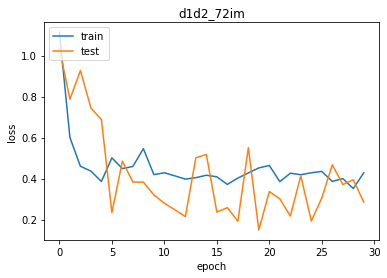

In [8]:
dir = os.path.join(r'C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\gitrepo\TeresaScheidt\training_results', name +'_loss.png')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(name)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(dir)
plt.show()

### Image prediction




In [9]:
out = []
model = keras.models.load_model(name)
for n in range(1):
    image = X_val[n]

    output = pred.predict(model, image, 128, 128, num_outputs=2)
    output_norm = pre.unnormalize(output, mean, std)
    out.append(output)
out = np.stack(out, axis = 0)

(144, 128, 128, 2)


In [10]:
im = out[0,:,:,0]
dir_d1 = os.path.join(r'C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\gitrepo\TeresaScheidt\training_results', name + '_d1.png')
dir_d2 = os.path.join(r'C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\gitrepo\TeresaScheidt\training_results', name +'_d2.png')
skimage.io.imsave(dir_d1, im)
im = out[0,:,:,1]
skimage.io.imsave(dir_d2, im)

Lossy conversion from float64 to uint8. Range [0.0, 5.021721839904785]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 2.378962755203247]. Convert image to uint8 prior to saving to suppress this warning.


In [10]:
out.shape

(5, 1104, 1104, 2)

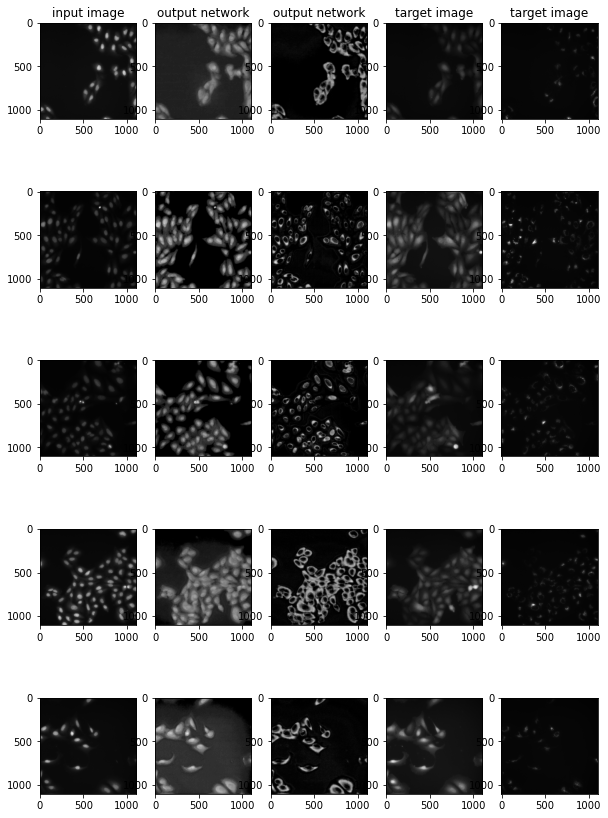

In [11]:
plt.figure(figsize=(10,15)) 

for p in range(5):
    plt.subplot(5,5,1+5*p)    
    plt.imshow(X_val[p], cmap='gray')
    if p == 0:
        plt.title('input image')

    plt.subplot(5,5,2+5*p)    
    plt.imshow(out[p,:,:,0], cmap='gray')
    if p == 0:
        plt.title('output network')
    
    plt.subplot(5,5,3+5*p)    
    plt.imshow(out[p,:,:,1], cmap='gray')
    if p == 0:
        plt.title('output network')

    plt.subplot(5,5,4+5*p) 
    plt.imshow(Y_val[p,:,:,0], cmap='gray')
    if p == 0:
        plt.title('target image')
        
    
    plt.subplot(5,5,5+5*p) 
    plt.imshow(Y_val[p,:,:,1], cmap='gray')
    if p == 0:
        plt.title('target image')
    
    

plt.show()

